# Callibration run

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from rich import print
from tqdm import tqdm

In [3]:
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

```py
 pip install ewatercycle-HBV
 pip install ewatercycle-DA
```

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
for path in [forcing_path, observations_path, figure_path, output_path]:
    path.mkdir(exist_ok=True)

Simple example using HBV:

In [5]:
from ewatercycle.forcing import sources

In [6]:
from ewatercycle_DA import DA

In [7]:
import ewatercycle_DA

In [8]:
n_particles = 200

In [10]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "1999-03-01T00:00:00Z"
HRU_id = 1620500
alpha = 1.26

This forcing file is availible at [https://github.com/Daafip/Msc-Thesis-Notebooks](https://github.com/Daafip/Msc-Thesis-Notebooks/tree/main/Forcing)

In [18]:
camels_forcing = sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha = alpha,
                          )

In [19]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5, 0])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

In [20]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [21]:
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [22]:
# values wihch you 
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'parameters':','.join([str(p) for p in p_intial[index]]), 
                            'initial_storage':','.join([str(s) for s in s_0]),
                             })

In [23]:
from ewatercycle_DA.local_models.HBV import HBVLocal

In [24]:
# this initializes the models for all ensemble members. 
ensemble.initialize(model_name=["HBVLocal"]*n_particles,
                    forcing=[camels_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst) 

In [25]:
ensemble.set_state_vector_variables('all')

In [26]:
ref_model = ensemble.ensemble_list[0].model

In [27]:
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)

time = []
assimilated_times = []
lst_state_vector = []
lst_Q = [] 
for i in tqdm(range(n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    ensemble.update(assimilate=False)
     
    lst_state_vector.append(ensemble.get_state_vector())
    lst_Q.append(ensemble.get_value("Q").flatten()) 

# end model - IMPORTANT! when working with dockers
ensemble.finalize()

100%|█████████████████████████████████████████| 577/577 [00:57<00:00, 10.11it/s]


In [28]:
Q_m_arr = np.array(lst_Q).T
state_vector_arr = np.array(lst_state_vector)
df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

Load obs

In [31]:
ds = xr.open_dataset(forcing_path / ref_model.forcing.pr)
observations = observations_path / f'0{HRU_id}_streamflow_qc.txt'
cubic_ft_to_cubic_m = 0.0283168466 
new_header = ['GAGEID','Year','Month', 'Day', 'Streamflow(cubic feet per second)','QC_flag']
new_header_dict = dict(list(zip(range(len(new_header)),new_header)))

df_Q = pd.read_fwf(observations,delimiter=' ',encoding='utf-8',header=None)
df_Q = df_Q.rename(columns=new_header_dict)
df_Q['Streamflow(cubic feet per second)'] = df_Q['Streamflow(cubic feet per second)'].apply(lambda x: np.nan if x==-999.00 else x)
df_Q['Q (m3/s)'] = df_Q['Streamflow(cubic feet per second)'] * cubic_ft_to_cubic_m
df_Q['Q'] = df_Q['Q (m3/s)'] / ds.attrs['area basin(m^2)'] * 3600 * 24 * 1000 # m3/s -> m/s ->m/d -> mm/d
df_Q.index = df_Q.apply(lambda x: pd.Timestamp(f'{int(x.Year)}-{int(x.Month)}-{int(x.Day)}'),axis=1)
df_Q.index.name = "time"
df_Q.drop(columns=['Year','Month', 'Day','Streamflow(cubic feet per second)'],inplace=True)
df_Q = df_Q.dropna(axis=0)
df_Q = df_Q.loc[time]

plot 

In [32]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [33]:
lst_nse = []
for i in range(n_particles):
    lst_nse.append(calc_NSE(df_Q['Q'],df_ensemble[f'particle {i}']))

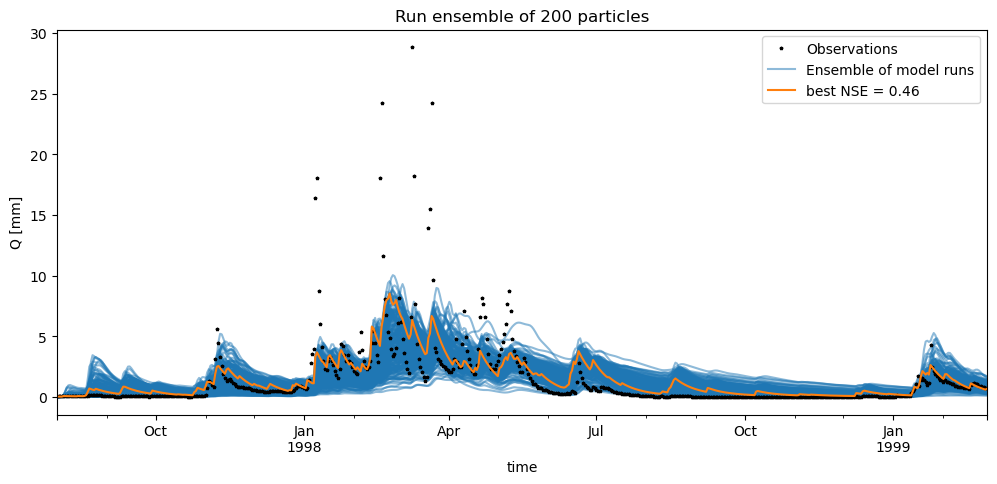

In [41]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
df_Q['Q'].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
df_ensemble.plot(ax=ax,alpha=0.5,zorder=-1,legend=False,color="C0")
df_ensemble[f'particle {np.array(lst_nse).argmax()}'].plot(ax=ax,color="C1",label=f'best NSE = {np.array(lst_nse).max():.2f}')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0],handles[1],handles[-1]],[labels[0],'Ensemble of model runs',labels[-1]],bbox_to_anchor=(1,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");